# Simplified Detection Efficiency Model

Update to: V. C. Chmielewski and E. C. Bruning (2016), Lightning Mapping Array flash detection performance with variable receiver thresholds, J. Geophys. Res. Atmos., 121, 8600-8614, doi:10.1002/2016JD025159

Description: Instead of propogating random sources to the network, this calculates the minimum power that a given number of stations can sense at each grid point. These minimum powers are then related to the distribution of source powers as described in the paper above to estimate the detection efficincy.

Contact:
vanna.chmielewski@noaa.gov

In [92]:
%matplotlib inline

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import may19_2013_obs_analysis.parsed_functions as pf
# from mpl_toolkits.basemap import Basemap
from may19_2013_obs_analysis.coordinateSystems import TangentPlaneCartesianSystem, GeographicSystem, MapProjection

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 2

In [94]:
c0 = 3.0e8 # m/s
dt_rms = 42.e-9 # seconds ; chosen from the best looking chi square fit from xlma gui 

sq = np.load('../../../LMAsimulation/source_quantiles',fix_imports=True, encoding='latin1',allow_pickle=True) # in Watts 
fde = 100-np.load('../../../LMAsimulation/fde.csv',fix_imports=True, encoding='latin1',allow_pickle=True) # Corresponding flash DE

### Station coordinates and thresholds from a set of log files 
#### Specify: 
* start time 
* end time 
* the directory holding the log files 
* any stations you wish to exclude from the analysis

In [95]:
# import read_logs
# import os
# import datetime

# # start_time = datetime.datetime(2014,5,26,2) #25 set
# # end_time   = datetime.datetime(2014,5,26,3,50)
# useddir = '/Users/Vanna/Documents/logs/'
# exclude = np.array(['W','A',])

# days = np.array([start_time+datetime.timedelta(days=i) for i in range((end_time-start_time).days+1)])
# days_string = np.array([i.strftime("%y%m%d") for i in days])

# logs = pd.DataFrame()
# dir = os.listdir(useddir)
# for file in dir:
#     if np.any(file[2:] == days_string) & np.all(exclude!=file[1]): 
#         print file
#         logs = logs.combine_first(read_logs.parsing(useddir+file,T_set='True'))

# aves = logs[start_time:end_time].mean()
# aves = np.array(aves).reshape(4,len(aves)/4).T

### Station coordinates from csv file

Input network title and csv file here

In [96]:
Network = 'OKLMA_DC3' # name of network in the csv file

# network csv file with one or multiple networks
stations = pd.read_csv('../../../LMAsimulation/network_full.csv') 

Order of active OKLMA stations (from station header) so as to match network_full.csv 

### Network_full.csv contains a total of 19 LMA stations whereas OKLMA station header files have only 18 stations

Station OKLMA_DC3 with alt = 393.99 (O_m) is the one that's extra in the network_full.csv list

1. Chickasha SE (C_m)
2. Dutton (D)
3. El Reno (E)
4. FAA (F_m)
5. Goldsby (G)
6. Chickasha N (H)
7. Minco SE (I)
8. Middleberg (M)
9. Newcastle (N)
10. Minco W (W_m)
11. Yukon (Y)
12. Altus Airport (A)
13. Prairie Hill (P)
14. Mangum (U)
15. Bluff (B)
16. Olustee (O)
17. Granite (R)
18. Zombie (Z)

In [97]:
# Remove stations FAA (F_m), Olustee (O), and Zombie (Z) as those were not active on May 19

all_data = stations.set_index('network')
oklma_data = all_data[all_data[' station'].isin([' C_m', ' D ', ' E ',
                                                ' G',' H ',' I ',' M ',' N ',
                                                ' W_m',' Y ',' A ',' P ',' U ',
                                                ' B ',' R '])]

aves = np.array(oklma_data)[:,:-1].astype('float')

### Converting and checking station locations

In [98]:
center = (np.mean(aves[:,1]), np.mean(aves[:,2]), np.mean(aves[:,0]))
geo  = GeographicSystem()
tanp = TangentPlaneCartesianSystem(center[0], center[1], center[2])
mapp = MapProjection
projl = MapProjection(projection='laea', lat_0=center[0], lon_0=center[1])

alt, lat, lon  = aves[:,:3].T

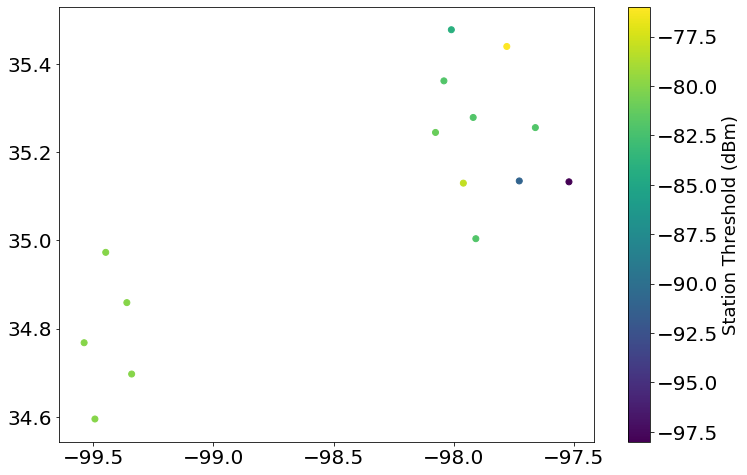

In [99]:
plt.scatter(lon, lat, c=aves[:,3])
plt.colorbar(label='Station Threshold (dBm)')
plt.show()

### Inclusive function for detection calculations

* Make sure the input array of station information matches the given dimensions
* Will check for solution in the line of sight for each station within 300 km of the network at the chosen altitude (default = 7 km) and grid spacing (default = 5 km)
* Minimum number of stations required to participate in solutions can be set (default = 6)

In [327]:
latp, lonp, sde, fde_a, minp = pf.quick_method(
                 # input array must be in N x (lat, lon, alt, threshold) 
                 np.array([aves[:,1],aves[:,2],aves[:,0],aves[:,3]]).transpose(), 
                 sq, fde, 
                 xint=5000, # Grid spacing
                 altitude=7000, # Altitude of grid MSL
                 station_requirement=6, # Minimum number of stations required to trigger
#                  mindist=200000
                )

/anaconda3/envs/segmentation/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


### Detection efficiency plots

In [101]:
domain = 197.5*1000
maps = Basemap(projection='laea', resolution='i',
               lat_0=center[0], lon_0=center[1], width=domain*2, height=domain*2)
x, y = maps(lonp, latp)

# Source detection efficiency
s = plt.pcolormesh(x,y,sde,cmap = 'magma')
plt.colorbar(label='Source Detection Efficiency')
s.set_clim(vmin=0,vmax=100)

# Draw flash detection efficiency contours
CS = plt.contour(x,y,fde_a, colors='k',levels=(20,40,60,70,80,85,90,95,99))
plt.clabel(CS, inline=1, fontsize=10,fmt='%3.0f')

# Overlay station locations
xs, ys = maps(lon,lat) 
plt.scatter(xs,ys, color='k',s=5)

maps.drawstates()
maps.drawcoastlines()
# maps.drawcounties()
plt.show()

NameError: name 'Basemap' is not defined

### Minimum Detectable Power plotting

In [ ]:
minp=np.ma.masked_where(minp==999,minp) # Undetected sources given value of 999

In [ ]:
domain = 197.5*1000
maps = Basemap(projection='laea', resolution='i',
               lat_0=center[0], lon_0=center[1], width=domain*2, height=domain*2)
x, y = maps(lonp, latp)

# Source detection efficiency
s = plt.pcolormesh(x,y,minp,cmap = 'viridis_r')
plt.colorbar(label='Minimum Detectable Power (dBW)')

# Overlay station locations
xs, ys = maps(lon,lat) 
plt.scatter(xs,ys, color='k',s=5)

maps.drawstates()
maps.drawcoastlines()
# maps.drawcounties()
plt.show()

____
______
## Additional functions

### Want to use cartopy to plot instead?

Start here

In [328]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

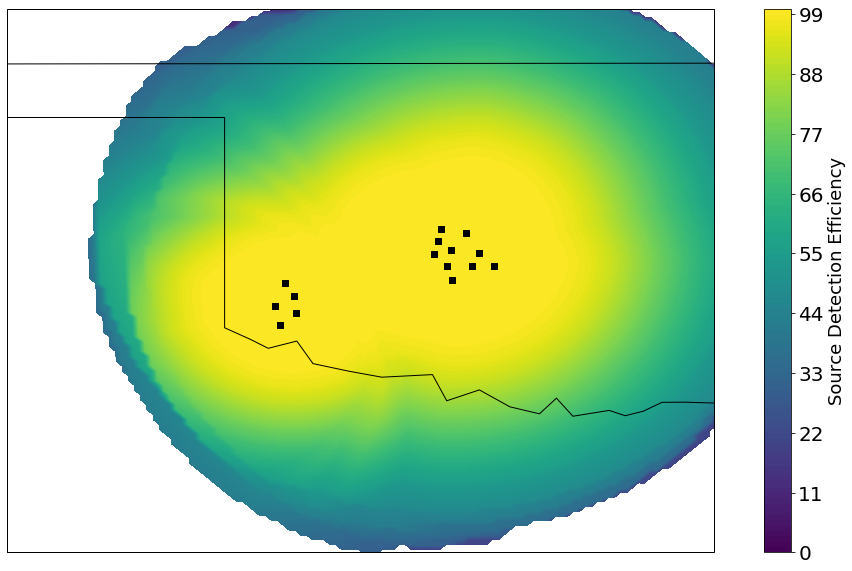

In [329]:
plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lonp, latp, np.ma.masked_where(sde<1, sde), 
             levels=np.arange(0,101,1), cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(label='Source Detection Efficiency')

plt.scatter(oklma_data[' lon'],oklma_data[' lat'],transform=ccrs.PlateCarree(),marker='s',color='k')
# plt.tiss

# ax.set_extent((-103, -90, 30, 40))
ax.set_extent([-102, -95.5, 32.5, 37.5])

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none')
lakes = cfeature.NaturalEarthFeature(
    category='physical',
    name='lakes',
    scale='110m',
    facecolor='none')
ax.add_feature(lakes, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
ax.coastlines()

plt.show()

In [336]:
iterations = 100
misses = np.load('misses_7km_MC.dat',allow_pickle=True)

xs  = 1000./np.arange(10,1000,1.) # Theoretical source detection efficiency that corresponds with fde
fde = 100-np.load('../../../LMAsimulation/fde.csv',fix_imports=True, encoding='latin1',allow_pickle=True) # Corresponding flash DE
sde1 = 100-np.mean(misses[0,:,:,:], axis=2)*100./iterations # Calculated source detection efficiency
fde_a = np.empty_like(sde1)

selects = sde1 == 100. # Put into the next lowest or equivalent flash DE from given source DE
fde_a[selects] = 100.
for i in range(len(xs)-1):
    selects = (sde1 >= xs[1+i]) & (sde1 < xs[i])
    fde_a[selects] = fde[i]

# Find center of 95% SOURCE detection efficiency
goods = (100-np.mean(misses[0,:,:,:], axis=2)*100./iterations)>95. 
de_centery = np.mean(initial_points[1,:,:,0][goods])
de_centerx = np.mean(initial_points[0,:,:,0][goods])

In [337]:
alts = np.array([7000])
initial_points = np.array(np.meshgrid(np.arange(xmin,xmax+xint,xint),
                                      np.arange(ymin,ymax+xint,xint), alts))

x,y,z=initial_points.reshape((3,int(np.size(initial_points)/3)))
points2 = np.array(projl.toECEF(x,y,z)).T

xp,yp,zp = points2.T
lonp,latp,zp = geo.fromECEF(xp,yp,zp)
latp = latp.reshape(np.shape(initial_points)[1],np.shape(initial_points)[2])
lonp = lonp.reshape(np.shape(initial_points)[1],np.shape(initial_points)[2])

#for 95% DE center
depts = np.array(projl.toECEF((de_centerx),(de_centery),alts)).T
xde,yde,zde = depts.T
londe,latde,zp = geo.fromECEF(xde,yde,zde)

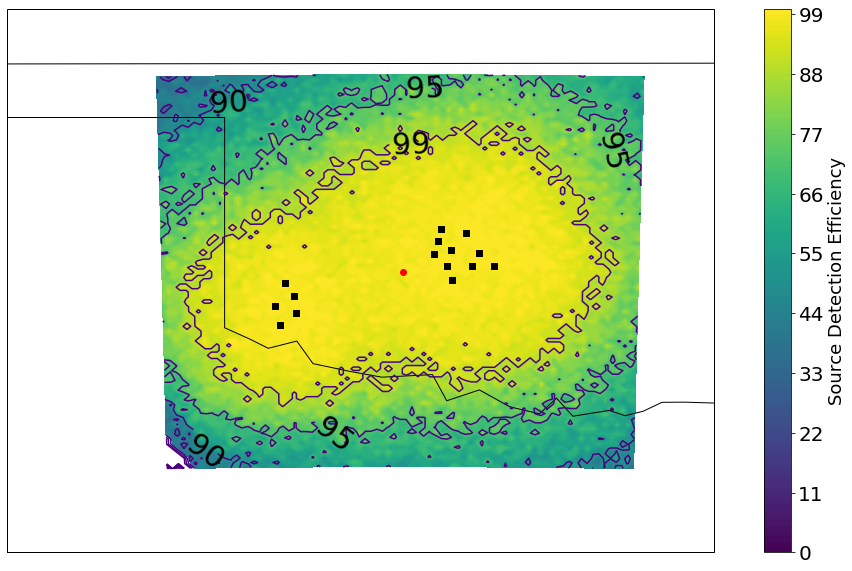

<Figure size 432x288 with 0 Axes>

In [339]:
plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lonp, latp, np.ma.masked_where(sde1<1, sde1), 
             levels=np.arange(0,101,1), cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(label='Source Detection Efficiency')

plt.scatter(oklma_data[' lon'],oklma_data[' lat'],transform=ccrs.PlateCarree(),marker='s',color='k')
CS = plt.contour(lonp,latp,fde_a, colors='indigo',levels=(20,40,60,70,80,85,90,95,99))
plt.clabel(CS, inline=1, fontsize=30,fmt='%3.0f',colors='k',
           rightside_up=True,)
# CS.collections[-1].set_linewidth(3)  

plt.scatter(londe,latde, color='r',transform=ccrs.PlateCarree())

# ax.set_extent((-103, -90, 30, 40))
ax.set_extent([-102, -95.5, 32.5, 37.5])

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none')
lakes = cfeature.NaturalEarthFeature(
    category='physical',
    name='lakes',
    scale='110m',
    facecolor='none')
ax.add_feature(lakes, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
ax.coastlines()

plt.show()


# plt.scatter(np.array([de_centerx+domain]), np.array([de_centery+domain]), color='r')

# maps.drawstates()
plt.tight_layout()
plt.show()

/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


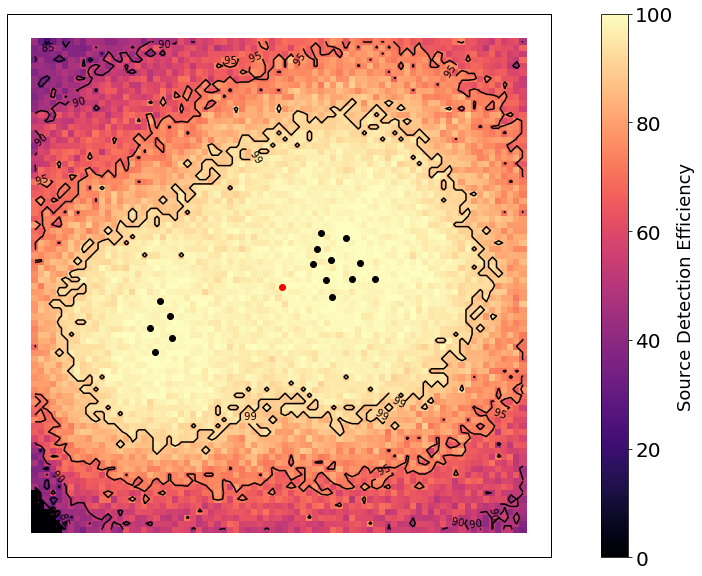

In [274]:
domain = 197.5*1000 # Relates back to domain size (xmax - xint/2) to shift map
# maps = Basemap(projection='laea', lat_0=center[0], lon_0=center[1], width=domain*2, height=domain*2)
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=center[1], central_latitude=center[0])

plt.figure(figsize=(18,10))
ax = plt.axes(projection=proj)

s = plt.pcolormesh(np.arange(xmin-xint/2.,xmax+3*xint/2.,xint)+domain,
                   np.arange(ymin-yint/2.,ymax+3*yint/2.,yint)+domain,
                   100-np.mean(misses[0,:,:,:], axis=2)*100./iterations,
                  cmap = 'magma',transform=proj)
s.set_clim(vmin=0,vmax=100)
plt.colorbar(label='Source Detection Efficiency')
CS = plt.contour(np.arange(xmin,xmax+xint,xint)+domain,
                   np.arange(ymin,ymax+yint,yint)+domain,
                   fde_a, colors='k',levels=(20,40,60,70,80,85,90,95,99))

plt.clabel(CS, inline=1, fontsize=10,fmt='%3.0f')
plt.scatter(stations_local[:,0]+domain, stations_local[:,1]+domain, color='k')
plt.scatter(np.array([de_centerx+domain]), np.array([de_centery+domain]), color='r')

# maps.drawstates()
plt.tight_layout()
plt.show()

### Want to try multiple network calculations at once?

Start here

In [45]:
stations = pd.read_csv('../../../LMAsimulation/network_full.csv') # network csv file with one or multiple networks

names = [['OKLMA_DC3','OKLMA_DC3sw','WTLMA'],
         'COLMA_DC3',
         'NALMA_DC3',
         ]

lats = [0]*len(names)
lons = [0]*len(names)
sdes = [0]*len(names)
fdes = [0]*len(names)
powr = [0]*len(names)

for i in range(len(names)):
    aves = np.array(stations.set_index('network').loc[names[i]])[:,:-1].astype('float')
#     aves[:,-1] = -78
    lats[i],lons[i],sdes[i],fdes[i],powr[i] = pf.quick_method(
        np.array([aves[:,1],aves[:,2],aves[:,0],aves[:,3]]).transpose(),
        sq, 
        fde, 
        xint=5000, 
        altitude=7000,
        station_requirement=7,
    )

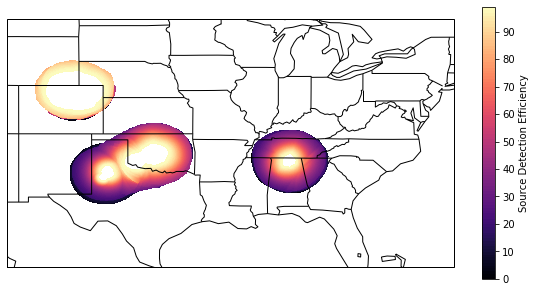

In [44]:
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())

for i in range(len(lats)):
#     plt.contourf(lons[i], lats[i], np.ma.masked_where(fdes[i]<50, fdes[i]), 
    plt.contourf(lons[i], lats[i], np.ma.masked_where(sdes[i]<1, sdes[i]), 
                 levels=np.arange(0,100,1), cmap='magma', transform=ccrs.PlateCarree())
plt.colorbar(label='Source Detection Efficiency')

ax.set_extent((-110, -73, 26, 45))
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none')
lakes = cfeature.NaturalEarthFeature(
    category='physical',
    name='lakes',
    scale='110m',
    facecolor='none')
ax.add_feature(lakes, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
ax.coastlines()

plt.show()

In [323]:
file = '/Users/ms/Desktop/mount/OKLMA_data_2013_cases/20130519/LYLOUT_130519_213000_0600.dat.gz'

In [545]:
import gzip
import pandas as pd
# f=gzip.open(file,'rb')
# file_content=f.read()
# print(file_content)

In [546]:
data = pd.read_csv(file,compression='gzip',skiprows=61,header=None,delimiter=r"\s+",
            names=['sec of day','lat','lon','alt(m)','reduced chi2','P(dBW)','mask'])
data

,sec of day,lat,lon,alt(m),reduced chi2,P(dBW),mask
0,77401.000982,35.348617,-97.544084,4877.45,0.18,6.7,0x0058d
1,77401.001123,35.348746,-97.544385,4887.16,0.14,7.9,0x0058d
2,77401.001598,35.346638,-97.546724,5391.00,4.97,5.9,0x0058d
3,77401.001820,35.348632,-97.543825,4933.60,0.30,7.3,0x0058d
4,77401.001882,35.347037,-97.546934,4933.59,0.36,8.1,0x0078d
...,...,...,...,...,...,...,...
585669,77999.923452,35.715771,-97.321872,9790.67,0.00,7.7,0x0058d
585670,77999.944689,35.716352,-97.321825,9287.39,0.53,8.5,0x0058d
585671,77999.956085,35.730055,-97.243199,10056.12,3.15,9.7,0x0078d
585672,77999.956672,35.759218,-97.163574,11842.97,0.29,12.0,0x11e0c


In [412]:
tt[0]

array([2.000e-03, 1.180e-02, 3.950e-02, 8.000e-02, 1.182e-01, 1.406e-01,
       1.358e-01, 1.157e-01, 9.220e-02, 7.690e-02, 5.500e-02, 3.870e-02,
       2.740e-02, 2.020e-02, 1.420e-02, 9.700e-03, 6.800e-03, 5.100e-03,
       2.900e-03, 2.800e-03, 1.800e-03, 7.000e-04, 6.000e-04, 4.000e-04,
       4.000e-04, 2.000e-04, 1.000e-04, 1.000e-04, 1.000e-04, 1.000e-04])

In [418]:
tt[1][5]

1.5940627479447338

In [414]:
np.where(tt[0] == tt[0].max())

(array([5]),)

In [409]:
mydata[7149]

42.526451276862936

In [449]:
powers = np.empty(10000)
for i in range(len(powers)):
    powers[i] = np.max(1./np.random.uniform(0,1000,2000))

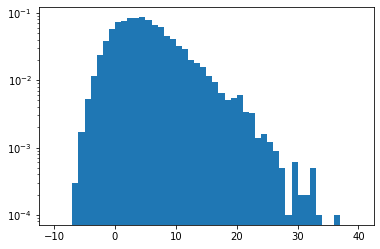

In [446]:
mydata = 10*np.log10(powers)
tt = plt.hist(mydata, bins=50,range=(-10,40),weights=np.zeros_like(mydata) + 1. / mydata.size,log=True)

(array([5.635e-01, 2.540e-01, 9.950e-02, 4.700e-02, 2.150e-02, 8.500e-03,
        2.500e-03, 2.500e-03, 5.000e-04, 5.000e-04]),
 array([-6.9065547 , -6.1010143 , -5.29547389, -4.48993348, -3.68439307,
        -2.87885266, -2.07331225, -1.26777184, -0.46223143,  0.34330897,
         1.14884938]),
 <a list of 10 Patch objects>)

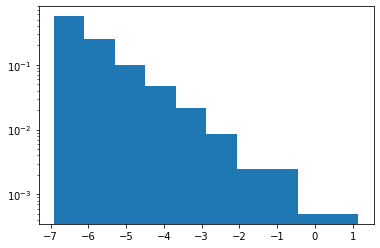

In [392]:
mydata = 1/np.random.uniform(0,1000,2000)
plt.hist(np.log(mydata),weights=np.zeros_like(mydata) + 1. / mydata.size,log=True)

(array([8.71133088e-03, 4.44675707e-01, 4.81429942e-01, 5.33846474e-02,
        9.90141273e-03, 1.53839849e-03, 2.49285439e-04, 7.00048150e-05,
        2.56115177e-05, 1.36594761e-05]),
 array([-9.3 ,  1.44, 12.18, 22.92, 33.66, 44.4 , 55.14, 65.88, 76.62,
        87.36, 98.1 ]),
 <a list of 10 Patch objects>)

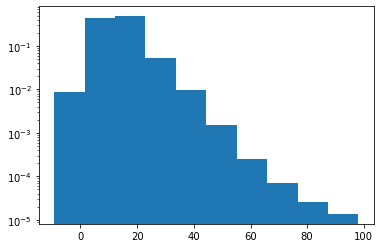

In [326]:
mydata = data['P(dBW)']
plt.hist(mydata, weights=np.zeros_like(mydata) + 1. / mydata.size,log=True)

In [236]:
res = stats.relfreq(1/np.random.uniform(0,1000,100000), numbins=25)

In [237]:
x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,
                                 res.frequency.size)

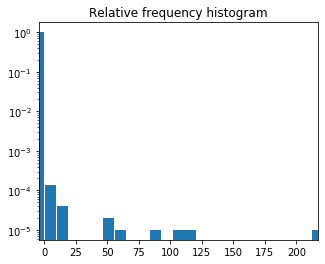

In [239]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x, res.frequency, width=res.binsize,log=True)
ax.set_title('Relative frequency histogram')
ax.set_xlim([x.min(), x.max()])

plt.show()

(array([6.7402e+04, 2.1870e+04, 7.2160e+03, 2.3590e+03, 7.3400e+02,
        2.6100e+02, 1.0700e+02, 3.9000e+01, 9.0000e+00, 3.0000e+00]),
 array([-39.99999133, -35.15074644, -30.30150154, -25.45225664,
        -20.60301175, -15.75376685, -10.90452195,  -6.05527706,
         -1.20603216,   3.64321274,   8.49245763]),
 <a list of 10 Patch objects>)

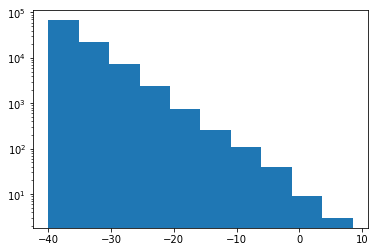

In [260]:
plt.hist(10*np.log10(1/np.random.uniform(0,10000,100000)),log=True)

In [258]:
10*np.log10(1000)

30.0

(array([374., 226., 108.,  63.,  40.,  28.,  20.,  17.,  13.,  11.]),
 array([ 0.16308056,  2.03485401,  3.90662747,  5.77840092,  7.65017437,
         9.52194782, 11.39372127, 13.26549472, 15.13726817, 17.00904162,
        18.88081507]),
 <a list of 10 Patch objects>)

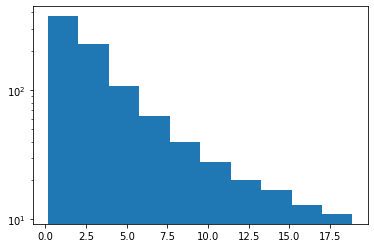

In [254]:
plt.hist(sq[1][:900],log=True)

In [266]:
stats.relfreq(10*np.log10(1/np.random.uniform(0,10000,100000)))

RelfreqResult(frequency=array([4.8073e-01, 3.8265e-01, 9.9820e-02, 2.6670e-02, 7.3600e-03,
       2.0900e-03, 4.7000e-04, 1.6000e-04, 4.0000e-05, 1.0000e-05]), lowerlimit=-42.857456048610196, binsize=5.714930867665203, extrapoints=0)

In [825]:
pp = []
for i in range(10000):
    pp.append(np.max(1/np.random.uniform(0,1000,2000)))

(array([0.0002, 0.0008, 0.0014, 0.004 , 0.0071, 0.0118, 0.0214, 0.0267,
        0.0332, 0.0397, 0.0481, 0.0561, 0.0566, 0.0639, 0.0604, 0.0554,
        0.055 , 0.053 , 0.0478, 0.0454, 0.037 , 0.0388, 0.0318, 0.0272,
        0.0259, 0.022 , 0.0196, 0.016 , 0.0129, 0.0107, 0.0088, 0.0094,
        0.0059, 0.0065, 0.0066, 0.0046, 0.0048, 0.0033, 0.0031, 0.0022,
        0.0023, 0.0017, 0.0018, 0.0012, 0.0015, 0.0008, 0.0011, 0.0005,
        0.0005, 0.0004, 0.0001, 0.0006, 0.0005, 0.0002, 0.0002, 0.0002,
        0.0001, 0.0001, 0.0003, 0.    , 0.0002, 0.    , 0.    , 0.0001,
        0.    , 0.0001, 0.0002, 0.    , 0.0001, 0.0001]),
 array([-6.85651712, -6.15127731, -5.4460375 , -4.74079769, -4.03555788,
        -3.33031808, -2.62507827, -1.91983846, -1.21459865, -0.50935885,
         0.19588096,  0.90112077,  1.60636058,  2.31160039,  3.01684019,
         3.72208   ,  4.42731981,  5.13255962,  5.83779943,  6.54303923,
         7.24827904,  7.95351885,  8.65875866,  9.36399846, 10.06923827,
 

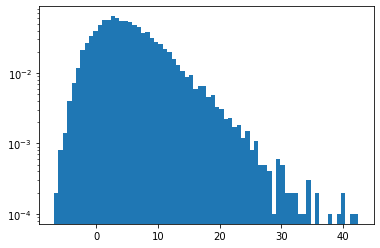

In [826]:
mydata = 10*np.log10(pp)
plt.hist(mydata,bins=70,weights=np.zeros_like(mydata) + 1. / mydata.size,log=True)

(array([9.921e+03, 4.000e+01, 9.000e+00, 8.000e+00, 5.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.06228313e-01, 2.54844618e+02, 5.09483007e+02, 7.64121396e+02,
        1.01875979e+03, 1.27339817e+03, 1.52803656e+03, 1.78

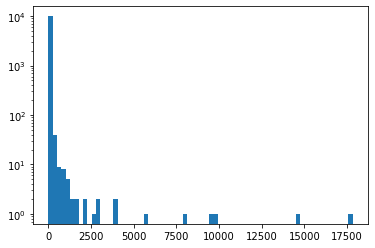

In [831]:
plt.hist(np.array(pp),bins=70,log=True)

(array([6.82973805e-06, 8.53717256e-06, 2.73189522e-05, 7.34196840e-05,
        4.04661979e-04, 2.13770801e-03, 6.05285534e-03, 1.29918692e-02,
        2.38511527e-02, 3.52090071e-02, 5.50152474e-02, 8.88344028e-02,
        1.08936029e-01, 1.19837999e-01, 1.24897127e-01, 1.03053917e-01,
        8.42482337e-02, 6.71687662e-02, 4.52316476e-02, 3.28681143e-02,
        2.39621359e-02, 1.55086277e-02, 1.11393028e-02, 8.84621820e-03,
        6.13310476e-03, 4.76886459e-03, 4.00393393e-03, 2.98459553e-03,
        2.46212057e-03, 2.20259052e-03, 1.58279179e-03, 1.26691641e-03,
        1.05007222e-03, 8.09323958e-04, 5.27597264e-04, 4.76374229e-04,
        3.05630778e-04, 2.28796225e-04, 2.11721879e-04, 1.43424499e-04,
        1.00738636e-04, 7.17122495e-05, 5.80527734e-05, 5.63453389e-05,
        4.09784283e-05, 2.56115177e-05, 3.24412557e-05, 2.04892141e-05,
        1.53669106e-05, 1.70743451e-05, 1.70743451e-05, 5.12230353e-06,
        5.12230353e-06, 1.36594761e-05, 5.12230353e-06, 6.829738

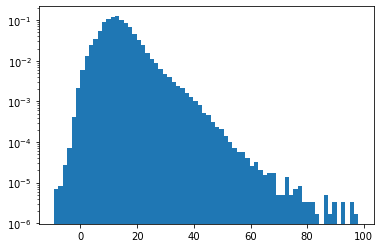

In [575]:
mydata = data['P(dBW)']
plt.hist(mydata,bins=70,weights=np.zeros_like(mydata) + 1. / mydata.size,log=True)

In [630]:
x,y,z=initial_points.reshape((3,int(np.size(initial_points)/3)))

In [645]:
dt, ran  = travel_time(points2, stations_ecef, c=c0, get_r=True)

In [663]:
mins = min_power((10**(ordered_threshs/10.))*1e-3,ran)
np.ma.set_fill_value(mins, 999)
req_power = np.partition(mins.filled(), station_requirement-1,axis=0)[station_requirement-1]

In [672]:
sde = np.zeros_like(req_power)
for i in range(len(sq[0])-1):
    selects = (req_power >= sq[1,i]) & (req_power < sq[1,i+1])
    sde[selects] = 100-sq[0,i+1]

In [767]:
sq

array([[0.00000000e+00, 1.00000000e-01, 2.00000000e-01, ...,
        9.97000000e+01, 9.98000000e+01, 9.99000000e+01],
       [1.63080563e-01, 2.92570636e-01, 3.25280456e-01, ...,
        6.52000649e+02, 9.88164451e+02, 2.49465134e+03]])

In [770]:
mydata = data['P(dBW)']

In [787]:
tt = np.arange(0,100,.1)

In [791]:
yy = []
for i in range(len(tt)):
    yy.append(np.quantile(mydata,tt[i]/100))

(array([0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.004,
        0.007, 0.013, 0.017, 0.026, 0.034, 0.051, 0.064, 0.084, 0.087,
        0.096, 0.085, 0.085, 0.068, 0.061, 0.045, 0.038, 0.027, 0.023,
        0.016, 0.013, 0.01 , 0.007, 0.006, 0.005, 0.004, 0.004, 0.002,
        0.003, 0.002, 0.002, 0.001, 0.002, 0.001, 0.001, 0.   , 0.001,
        0.   , 0.001, 0.   , 0.   , 0.001]),
 array([-9.3 , -8.15, -7.  , -5.85, -4.7 , -3.55, -2.4 , -1.25, -0.1 ,
         1.05,  2.2 ,  3.35,  4.5 ,  5.65,  6.8 ,  7.95,  9.1 , 10.25,
        11.4 , 12.55, 13.7 , 14.85, 16.  , 17.15, 18.3 , 19.45, 20.6 ,
        21.75, 22.9 , 24.05, 25.2 , 26.35, 27.5 , 28.65, 29.8 , 30.95,
        32.1 , 33.25, 34.4 , 35.55, 36.7 , 37.85, 39.  , 40.15, 41.3 ,
        42.45, 43.6 , 44.75, 45.9 , 47.05, 48.2 ]),
 <a list of 50 Patch objects>)

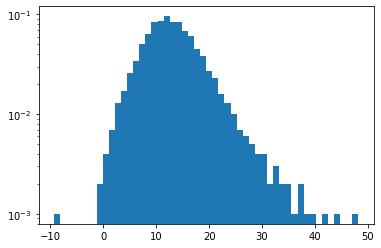

In [802]:
plt.hist(yy,bins=50,weights=np.zeros_like(yy) + 1. / len(yy),log=True)

(array([0.001, 0.   , 0.   , 0.003, 0.006, 0.011, 0.021, 0.031, 0.043,
        0.053, 0.06 , 0.068, 0.07 , 0.071, 0.07 , 0.064, 0.058, 0.054,
        0.047, 0.041, 0.035, 0.031, 0.026, 0.023, 0.019, 0.016, 0.013,
        0.012, 0.009, 0.008, 0.006, 0.005, 0.004, 0.004, 0.003, 0.002,
        0.003, 0.001, 0.002, 0.001, 0.001, 0.001, 0.   , 0.001, 0.   ,
        0.001, 0.   , 0.   , 0.   , 0.001]),
 array([-7.87597798, -7.03905645, -6.20213492, -5.36521339, -4.52829186,
        -3.69137033, -2.8544488 , -2.01752727, -1.18060573, -0.3436842 ,
         0.49323733,  1.33015886,  2.16708039,  3.00400192,  3.84092345,
         4.67784498,  5.51476651,  6.35168804,  7.18860957,  8.0255311 ,
         8.86245264,  9.69937417, 10.5362957 , 11.37321723, 12.21013876,
        13.04706029, 13.88398182, 14.72090335, 15.55782488, 16.39474641,
        17.23166794, 18.06858947, 18.90551101, 19.74243254, 20.57935407,
        21.4162756 , 22.25319713, 23.09011866, 23.92704019, 24.76396172,
        25.60088

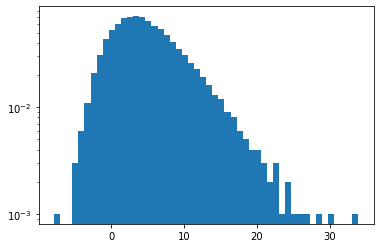

In [827]:
plt.hist(10*np.log10(sq[1]),bins=50,weights=np.zeros_like(sq[1]) + 1. / len(sq[1]),log=True)

(array([0.962, 0.019, 0.006, 0.003, 0.002, 0.002, 0.001, 0.001, 0.   ,
        0.001, 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.001]),
 array([1.63080563e-01, 5.00528458e+01, 9.99426110e+01, 1.49832376e+02,
        1.99722141e+02, 2.49611907e+02, 2.99501672e+02, 3.49391437e+02,
        3.99281202e+02, 4.49170967e+02, 4.99060733e+02, 5.48950498e+02,
        5.98840263e+02, 6.48730028e+02, 6.98619793e+02, 7.48509559e+02,
        7.98399324e+02, 8.48289089e+02, 8.98178854e+02, 9.48068619e+02,
        9.97958385e+02, 1.04784815e+03, 1.09773791e+03, 1.14762768e+03,
        1.19751745e+03, 1.24740721e+03, 1.29729698e+03, 1.34718674e+03,
        1.39707651e+03, 1.44696627e+03, 1.49685604e+03, 1.54674580e+03,
        1.59663557e+03, 

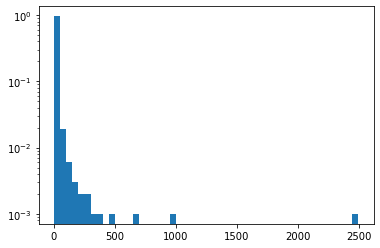

In [830]:
plt.hist(sq[1],bins=50,weights=np.zeros_like(sq[1]) + 1. / len(sq[1]),log=True)

In [806]:
xs  = 1000./np.arange(10,1000,1.)

In [813]:
tt = (req_power >= sq[1,0]) & (req_power < sq[1,1])

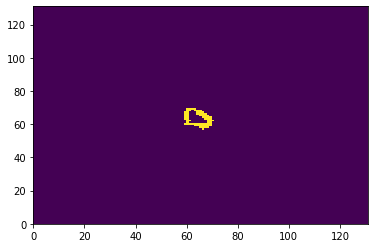

In [815]:
plt.pcolormesh(tt.reshape(lonp.shape[0],latp.shape[0]))